In [11]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import pylab
from scipy.optimize import curve_fit, leastsq

pd.set_option('display.max_columns', 500)
sns.set_style('whitegrid')

In [12]:
# load data

df_cases_raw = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv", index_col=False)
df_deaths_raw = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv", index_col=False)
df_recoveries_raw = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv", index_col=False)

In [13]:
df_cases_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790


In [14]:
# group countries

df_cases_grouped = df_cases_raw.groupby(by='Country/Region', as_index=False).agg('sum')
top_cases = df_cases_grouped.nlargest(10, df_cases_raw.columns[-1])['Country/Region']
print top_cases

28              China
70              Italy
66               Iran
129             Spain
53            Germany
49             France
76       Korea, South
143                US
134       Switzerland
146    United Kingdom
Name: Country/Region, dtype: object


In [21]:
def preprocess_frame(df):
    df = df.groupby(by='Country/Region', as_index=False).agg('sum')
    df = df.drop(['Lat', 'Long'], 1)
    df = df.set_index('Country/Region').T
    df['Date'] = df.index
    df.insert(0, 'Day', range(0, len(df)))
    df["notChina"] = df.drop(['Day', 'China', 'Date'], axis=1).sum(axis=1)
    return df

df_cases = preprocess_frame(df_cases_raw)
df_deaths = preprocess_frame(df_deaths_raw)
df_recoveries = preprocess_frame(df_recoveries_raw)



In [22]:
def shift_to_day_zero(df, df_reference):
    for key in df.columns:
        if key!= 'Date' and key!='Day' :
            if df_reference[key].sum()>0:
                df[key] = df[key].shift(-df_reference['Day'][df_reference[key]>0].iloc[0])
    

df_cases_reference = df_cases.copy()
shift_to_day_zero(df_cases, df_cases_reference)
shift_to_day_zero(df_deaths, df_cases_reference)
shift_to_day_zero(df_recoveries, df_cases_reference)

In [23]:
def normalize(df):
    for key in df.columns:
        if key != 'Date' and key!='Day':
            df[key] = df[key]/df[key].max()
            

#normalize(df_cases)

<IPython.core.display.Javascript object>


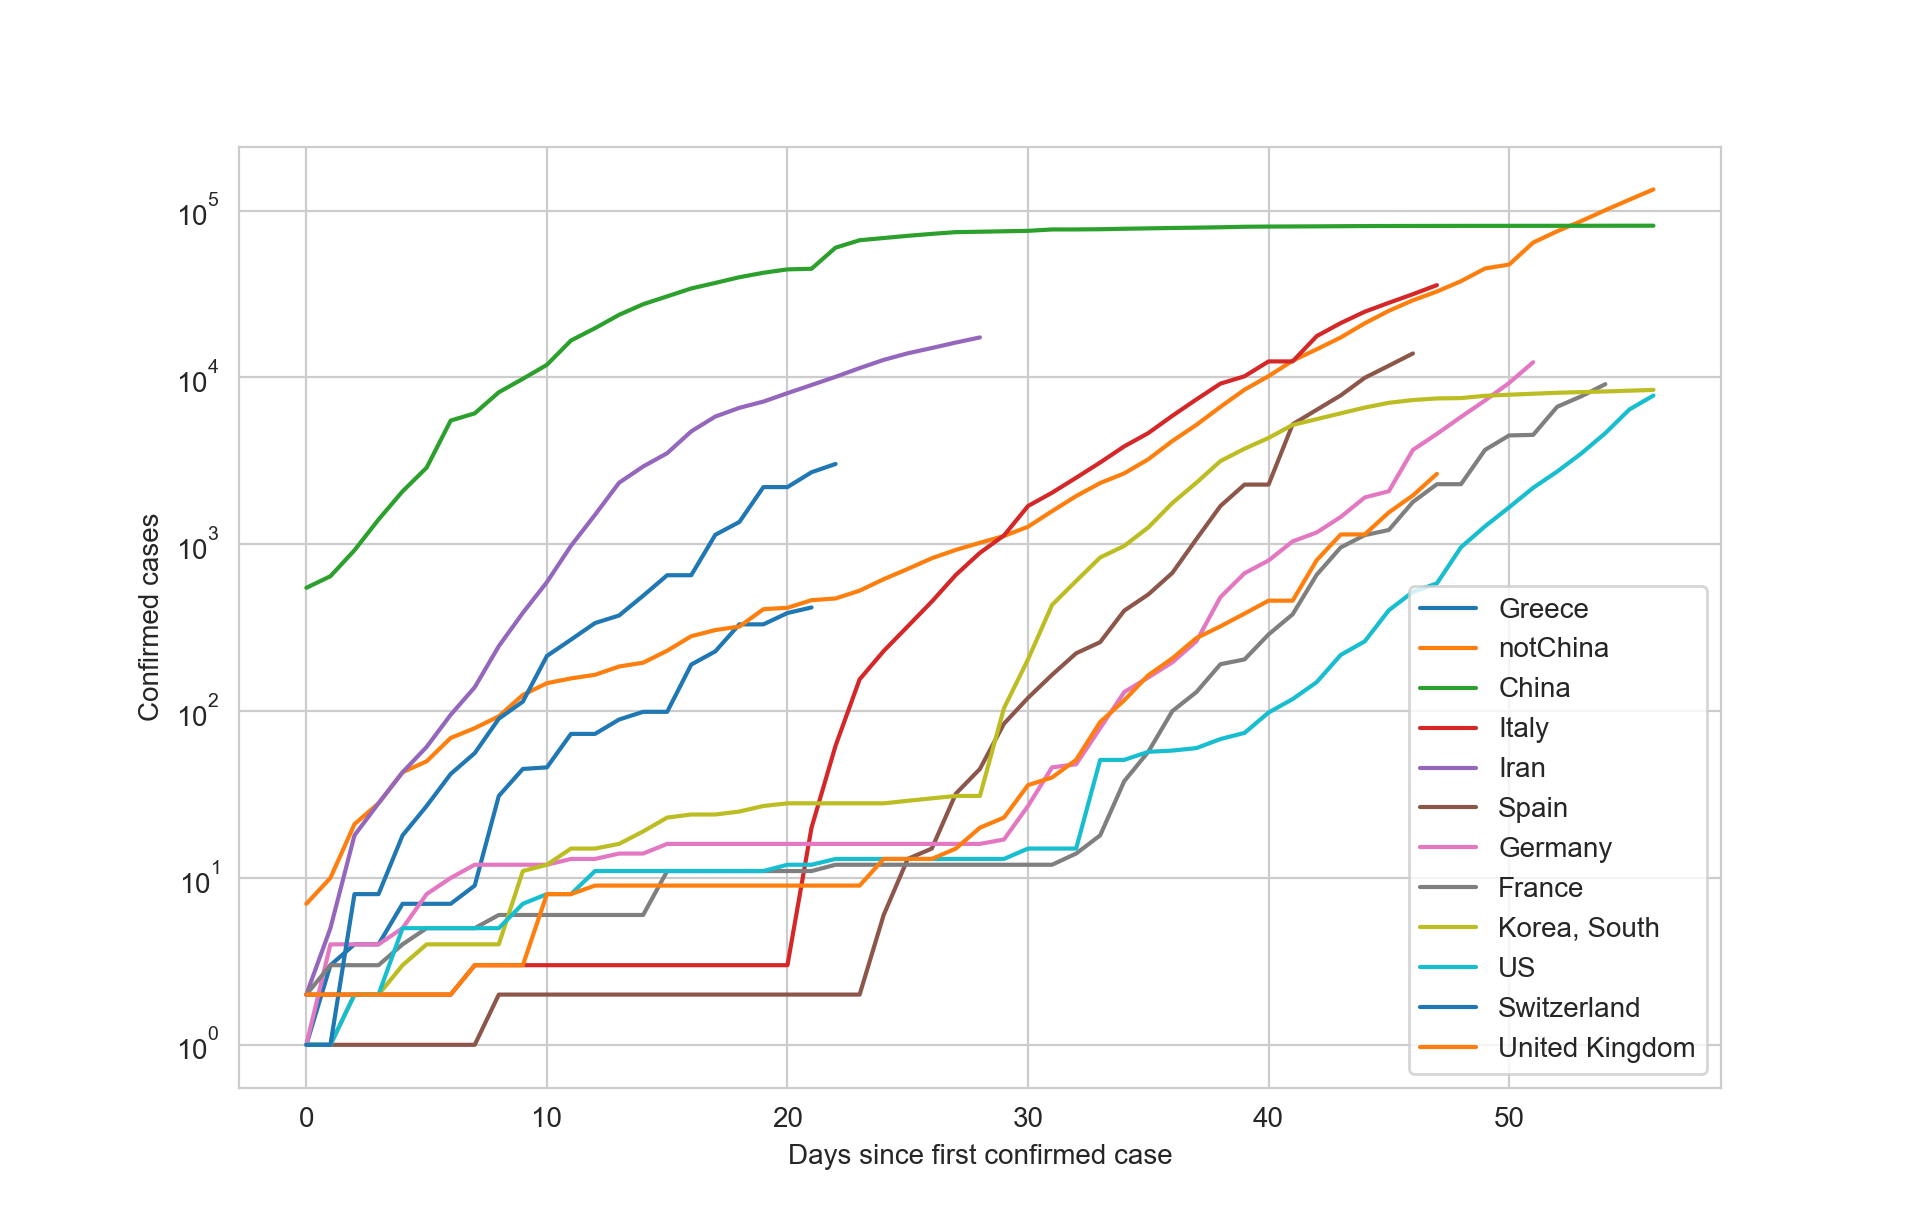

In [18]:
%matplotlib notebook

countries = top_cases
def plot_confirmed_cases(df, countries):
    g = sns.lineplot(df['Day'], df['Greece'], label='Greece')
    sns.lineplot(df['Day'], df['notChina'], label='notChina')
    for country in countries:
        sns.lineplot(df['Day'], df[country], label=country)
    g.set(xlabel='Days since first confirmed case', ylabel='Confirmed cases')
    g.set_yscale("log")
    plt.legend()
 

plot_confirmed_cases(df_cases, countries)

<IPython.core.display.Javascript object>


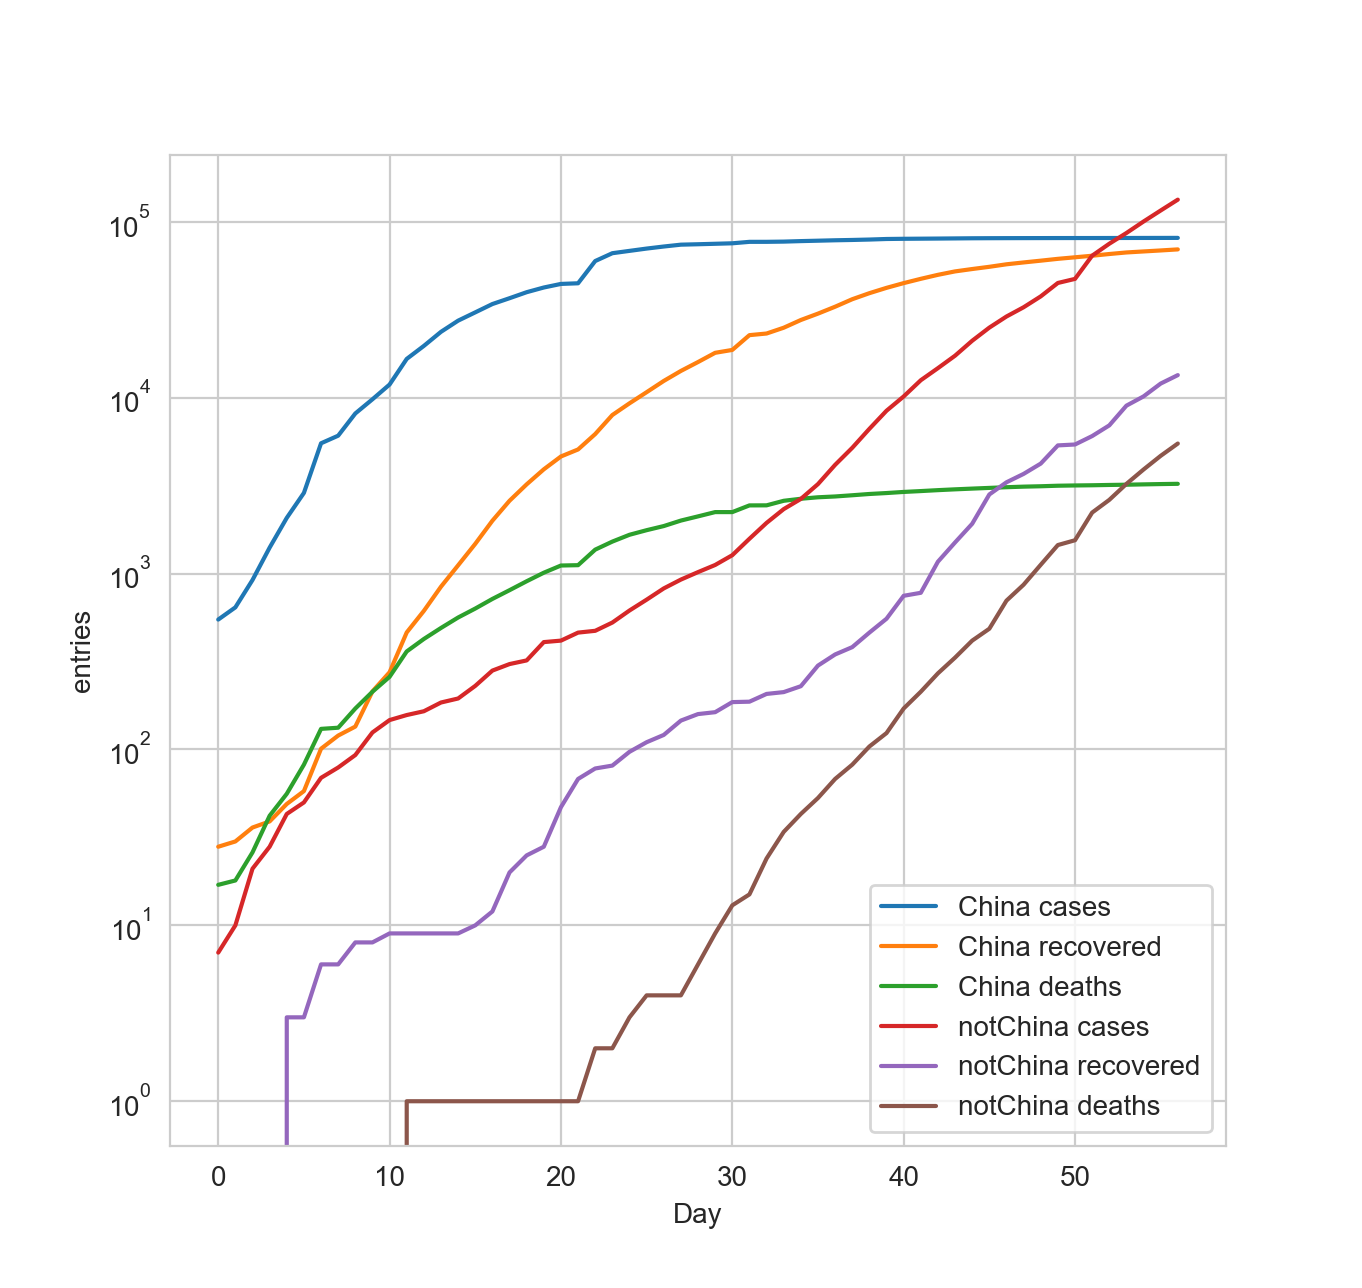

In [95]:
%matplotlib notebook

def plot_case_death_recovery(country):
    g = sns.lineplot(df_cases['Day'], df_cases[country], label=country+' cases')
    sns.lineplot(df_recoveries['Day'], df_recoveries[country], label=country+' recovered')
    sns.lineplot(df_deaths['Day'], df_deaths[country], label=country+' deaths')
    g.set(ylabel='entries')
    g.set_yscale("log")
    plt.legend()

plot_case_death_recovery('China')
plot_case_death_recovery('notChina')


Fit:
x0 = 17.5580481127
k  = 0.214580872927
a  = 82368.7636763
c  = -1319.24916612
Asymptotes are -1319.24916612 and 81049.5145102
[  1.75580481e+01   2.14580873e-01   8.23687637e+04  -1.31924917e+03]


<IPython.core.display.Javascript object>


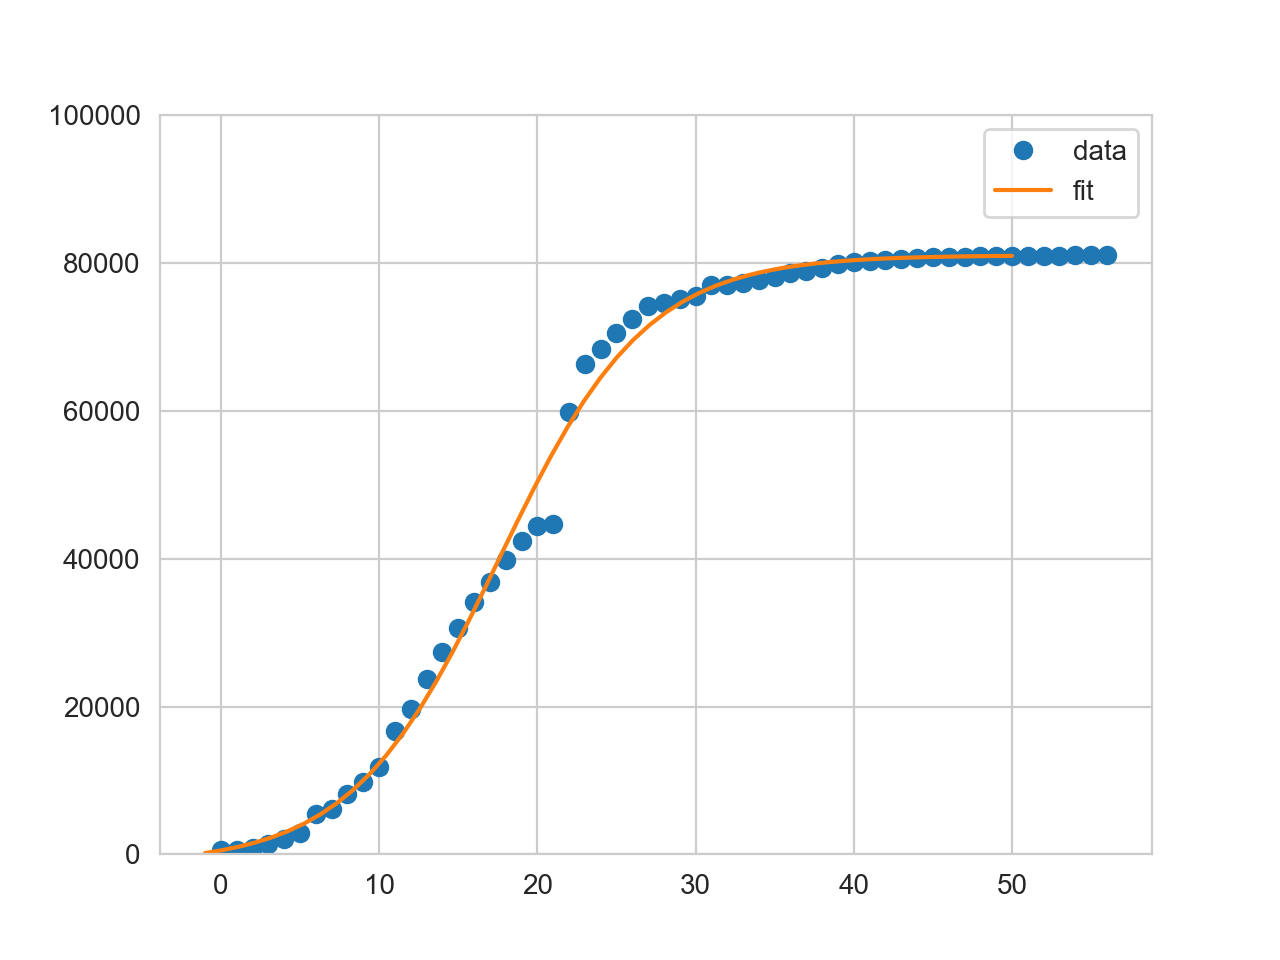

In [91]:
%matplotlib notebook

def sigmoid(x, x0, k, a, c):
     y = a / (1 + np.exp(-k*(x-x0))) + c
     return y

xdata, ydata = df_cases['Day'], df_cases['China']
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0=(1.0, -1.0, 1.0, 0.0))
print "Fit:"
print "x0 =", popt[0]
print "k  =", popt[1]
print "a  =", popt[2]
print "c  =", popt[3]
print "Asymptotes are", popt[3], "and", popt[3] + popt[2] 

print popt

x = np.linspace(-1, 50, 50)
y = sigmoid(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 100000)
pylab.legend(loc='best')
pylab.show()



<IPython.core.display.Javascript object>


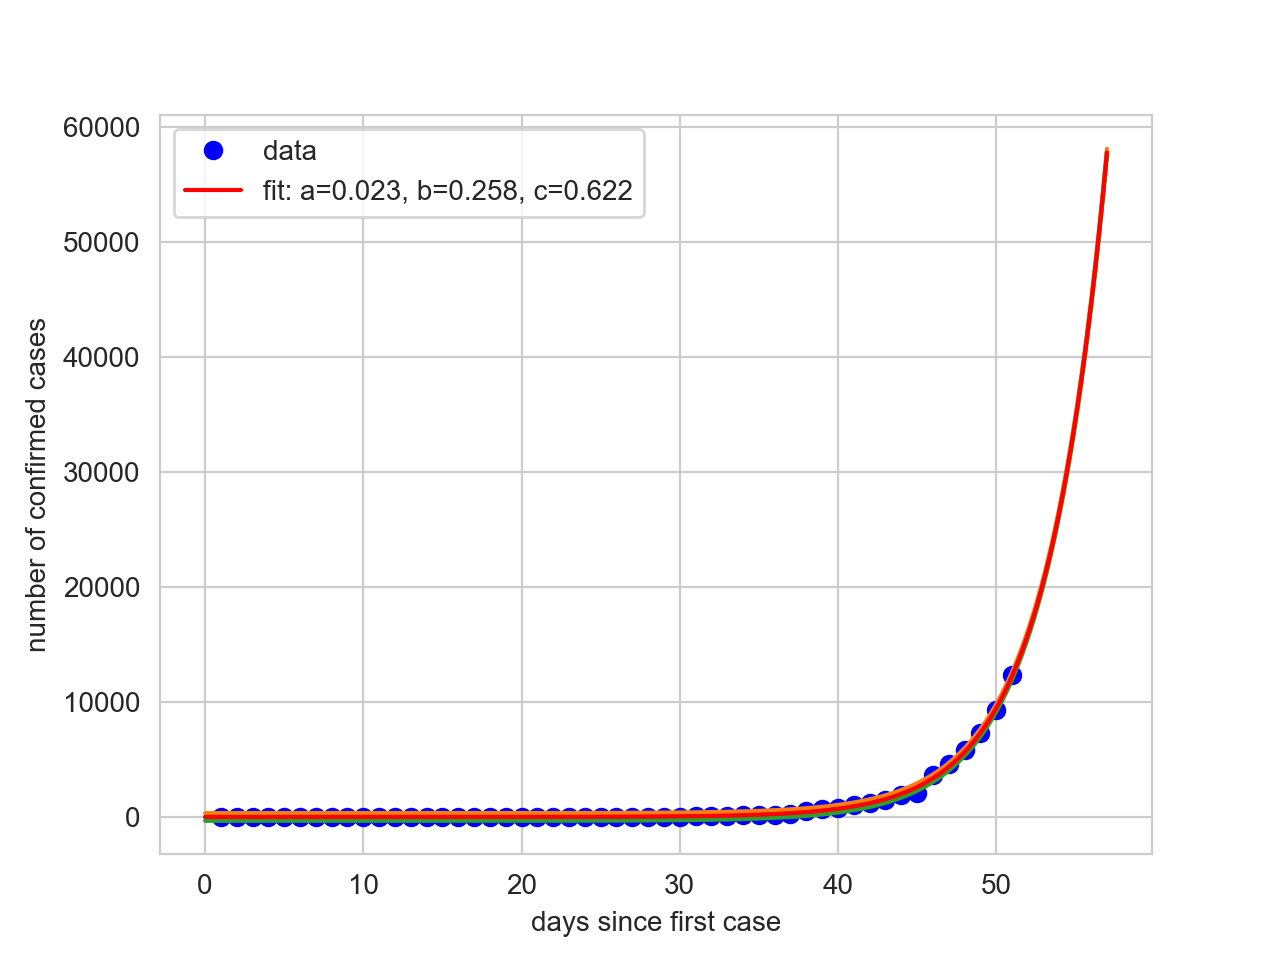

In [10]:
%matplotlib notebook

country = 'Germany'
day0 = 0
today = df_cases[country].dropna().shape[0]

df_cases_fit = df_cases.copy()
xdata = df_cases['Day'][(df_cases['Day']>day0) & (df_cases['Day']<today)]
ydata = df_cases[country][(df_cases['Day']>day0) & (df_cases['Day']<today)]
x = np.linspace(day0, today+5 , 1000)

def func(x, a, b, c):
    return a * np.exp(b * x) + c

pylab.plot(xdata, ydata, 'bo', label='data')

popt, pcov = curve_fit(func, xdata, ydata, [10,0.5,0.1], bounds=([-500,-500,0],[500,500,5]), method="dogbox")
popt

#sigma = [pcov[0,0], pcov[1,1], pcov[2,2]]
#pylab.plot(x, func(x, popt[0], popt[1], popt[2]),
#         x, func(x, popt[0] + sigma[0], popt[1] - sigma[1], popt[2] + sigma[2]),
#         x, func(x, popt[0] - sigma[0], popt[1] + sigma[1], popt[2] - sigma[2])  
#         )

#pylab.plot(x, func(x, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))


#popt[0] = 0.006
#popt[1] = 0.287
#popt[2] = 54.15
#popt2, pcov2 = leastsq(func=residuals, x0=(1.,1.,1.,1.), args=(x,func(x, *popt)))
#pylab.plot(x, func(x, *popt2), 'g-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

pylab.xlabel('days since first case')
pylab.ylabel('number of confirmed cases')
pylab.legend()
#pylab.yscale("log")
pylab.show()

In [65]:
func(0, *popt)

7.7176453768949358

In [114]:
pcov

array([[  1.08095343e-38,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])